# Tutorial 2 - 3D Examples for MDVContainment
To get acquanted with the functionalities of MDVContainment we start with 3D systems due to their clean visualization. Visualization of 3D systems makes use of VMD in this tutorial. However, feel free to visualize the generated GRO files with your favorite software.

1) Single island in ocean
2) Nested islands in ocean
3) Translation invariance (up to voxel resolution)
4) Multiple outsides
5) Closing (small) holes
6) Diagonal neighbours are included

## Dependencies

In [1]:
import mdvcontainment as mdvc
import MDAnalysis as mda
import numpy as np
import matplotlib.pyplot as plt
import webbrowser
import networkx as nx
import matplotlib.image as mpimg

## Visualization wrapper

In [2]:
def visualize_3D(name, command_string='-e visualization.vmd'):
    """
    Visualizes the GRO file using the included render settings.

    Feel free to change this function to whatever visualizer you prefer.
    """
    # Plot using VMD
    !vmd $name $command_string
    return

In [3]:
def draw_containment_nx(G, images, write=True, fname='containment.png', imsize=0.2, lwidth=1, nodesize=0, dpi=300):
    """
    Draws the containment graph using networkx and the provided images.

    Returns the plot object.
    """
    node_size = np.max(mpimg.imread(images[list(images.keys())[0]]).shape)*nodesize

    # The amount of images
    N = len(images)

    # Setting up the layout of the graph coordinates
    #pos=nx.spring_layout(G,k=k)
    pos = nx.nx_agraph.graphviz_layout(G, prog='dot')

    # draw with images on nodes
    nx.draw_networkx(G,pos,width=lwidth,edge_color="grey",alpha=1, node_size=node_size, node_color='white', arrows=False)
    ax=plt.gca()
    ax.axis('off')
    fig=plt.gcf()
    trans = ax.transData.transform
    trans2 = fig.transFigure.inverted().transform
    for n in G.nodes():
        (x,y) = pos[n]
        xx,yy = trans((x,y)) # figure coordinates
        xa,ya = trans2((xx,yy)) # axes coordinates
        a = plt.axes([xa-imsize/2.0,ya-imsize/2.0, imsize, imsize ])
        a.imshow(mpimg.imread(images[n]))
        a.set_aspect('equal')
        a.axis('off')
    if write:
        plt.savefig(fname, dpi=dpi, bbox_inches="tight")
    return plt

## Data generation funtions
Some helper functions to easily generate GRO files from voxel masks.

In [4]:
def make_test_universe(voxels, angles=(90,90,90)):
    """
    Returns a universe filled with the specified points.
    """

    # Obtaining the PBC shape in Anghstrom (A)
    dim = np.array(voxels.shape)*10
    
    # Converting the voxels to points and 
    #  changing the distance unit from nm to A and 
    #  adding a 5 A offset. 
    coordinates_fill = (np.vstack(np.where(voxels != 0)).T)*10 + 5
    coordinates_empty = (np.vstack(np.where(voxels == 0)).T)*10 + 5
    
    # Creating the empty univerese
    universe = mda.Universe.empty(
        n_atoms = coordinates_fill.shape[0] + coordinates_empty.shape[0],
        trajectory = True,
    )
    
    # Fill the universe with the positions
    universe.atoms.positions = np.vstack([coordinates_fill, coordinates_empty])
    
    # Creating the atom names
    names = ['A']*coordinates_fill.shape[0] + ['B']*coordinates_empty.shape[0]
    universe.add_TopologyAttr('name', names)
    
    # Add the PBC conditions
    universe.dimensions = [*dim, *angles]
    
    return universe

In [5]:
def make_island_3D(name='island_3D.gro', roll=0, visualize=True):
    """
    Returns and writes the atomgroup for a simple island in the ocean (3D).
    """

    # Creating the boolean mask.
    shape = (10, 10 , 10)
    voxels = np.zeros(shape)
    voxels[3:7, 3:7, 3:7] = 1
    
    # Translate periodically 
    voxels = np.roll(voxels, roll, 0)
    voxels = np.roll(voxels, roll, 1)
    voxels = np.roll(voxels, roll, 2)

    # Creating the universe
    test_universe = make_test_universe(voxels)
    test_universe.atoms.write(name)

    # Plot
    if visualize:
        visualize_3D(name)
    
    return test_universe

In [6]:
def make_nested_island_3D(name='nested_island_3D.gro', roll=0, visualize=True):
    """
    Returns and writes the atomgroup for a nesyed island in the ocean (3D).
    """

    # Creating the boolean mask
    shape = (10, 10 , 10)
    voxels = np.zeros(shape)
    voxels[2:8, 2:8, 2:8] = 1
    voxels[3:7, 3:7, 3:7] = 0
    voxels[4:6, 4:6, 4:6] = 1
    
    # Translate periodically 
    voxels = np.roll(voxels, roll, 0)
    voxels = np.roll(voxels, roll, 1)
    voxels = np.roll(voxels, roll, 2)

    # Creating the universe
    test_universe = make_test_universe(voxels)
    test_universe.atoms.write(name)

    # Plot
    if visualize:
        visualize_3D(name)
    
    return test_universe

In [7]:
def make_cylinders_3D(name='cylinder_3D.gro', roll=0, visualize=True):
    """
    Returns and writes the atomgroup for a system with nested rank1 cylinders (3D).
    """

    # Creating the boolean mask.
    shape = (10, 10 , 10)
    voxels = np.zeros(shape)
    
    # First row
    voxels[3:7, 3:7, :] = 1
    voxels[4:6, 4:6, :] = 0
    
    # Translate periodically 
    voxels = np.roll(voxels, roll, 0)
    voxels = np.roll(voxels, roll, 1)
    voxels = np.roll(voxels, roll, 1)

    # Creating the universe
    test_universe = make_test_universe(voxels)
    test_universe.atoms.write(name)

    # Plot
    if visualize:
        visualize_3D(name)
    
    return test_universe

In [8]:
def make_complex_3D(name='cylinder_3D.gro', roll=0, visualize=True):
    """
    Returns and writes the atomgroup for a complex system(3D).
    """

    # Creating the boolean mask.
    shape = (23, 10 , 10)
    voxels = np.zeros(shape)
    
    # Add the cylinders
    voxels[3:7, 3:7, :] = 1
    voxels[4:6, 4:6, :] = 0

    # Add the nested islands
    voxels[15:21, 2:8, 2:8] = 1
    voxels[16:20, 3:7, 3:7] = 0
    voxels[17:19, 4:6, 4:6] = 1

    # Add dividing plane
    voxels[10:13, :, :] = 1

    # Add island in dividing plane
    voxels[11, 5, 5] = 0
    
    # Translate periodically 
    voxels = np.roll(voxels, roll, 0)
    voxels = np.roll(voxels, roll, 1)
    voxels = np.roll(voxels, roll, 1)

    # Creating the universe
    test_universe = make_test_universe(voxels)
    test_universe.atoms.write(name)

    # Plot
    if visualize:
        visualize_3D(name)
    
    return test_universe

## 1 - Island
This is the most basic of containment hierarchies. We do not use blurring, as we have voxel perfect input.

In [9]:
# Generate the test data
base_name = 'island_3D'
make_island_3D(base_name + '.gro', visualize=False) # Set visualize to true for a VMD rendering

/home/bart/.virtualenvs/containment/lib/python3.8/site-packages/MDAnalysis/coordinates/GRO.py:421: UserWarning: Supplied AtomGroup was missing the following attributes: resnames, resids. These will be written with default values. Alternatively these can be supplied as keyword arguments.
  warnings.warn(


<Universe with 1000 atoms>

In [10]:
# Load the GRO
u = mda.Universe(base_name + '.gro')
# Make the required selection
selection = u.select_atoms('name is A')

/home/bart/.virtualenvs/containment/lib/python3.8/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: A
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))


In [11]:
# Generate the containment hierarchy
containers = mdvc.Containers(selection.atoms, resolution=1, blur_amount=0)

Creating voxel masks with a resolution of 1...
Blurring voxel masks with 0...
Non PBC-labeling...
Obtaining bridges...
Calculating the ranks...
The ranks are {(1,): 0, (-1,): 3}
Calculating the pairs...
Relabeling taking PBC into account...
Creating graphs...
Annotating the containment graph...
Done!


In [12]:
# Write the components pdb (the components are in the beta field, the containment in the containment.vmd)
containers.write_components(fname_struc=f'{base_name}_containment.pdb', fname_vmd=f'{base_name}_containment.vmd')

/home/bart/.virtualenvs/containment/lib/python3.8/site-packages/MDAnalysis/coordinates/PDB.py:1129: UserWarning: Found no information for attr: 'altLocs' Using default value of ' '
  warnings.warn("Found no information for attr: '{}'"
/home/bart/.virtualenvs/containment/lib/python3.8/site-packages/MDAnalysis/coordinates/PDB.py:1129: UserWarning: Found no information for attr: 'icodes' Using default value of ' '
  warnings.warn("Found no information for attr: '{}'"
/home/bart/.virtualenvs/containment/lib/python3.8/site-packages/MDAnalysis/coordinates/PDB.py:1129: UserWarning: Found no information for attr: 'chainIDs' Using default value of ''
  warnings.warn("Found no information for attr: '{}'"
/home/bart/.virtualenvs/containment/lib/python3.8/site-packages/MDAnalysis/coordinates/PDB.py:1129: UserWarning: Found no information for attr: 'occupancies' Using default value of '1.0'
  warnings.warn("Found no information for attr: '{}'"
/home/bart/.virtualenvs/containment/lib/python3.8/site-

In [13]:
## Show the objects (use as selection all, with visualization of VDW and coloring set to beta to see the components)
# visualize_3D(f'{base_name}_containment.pdb', command_string='-e components.vmd')

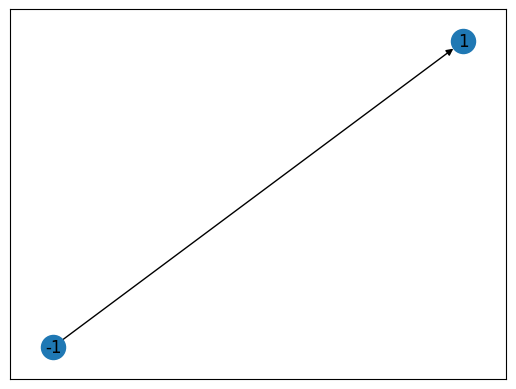

In [14]:
# Draw the raw containment graph using networkx
nx.draw_networkx(containers.containment_graph)

In [15]:
#comment
# This has to be the first line to capture the output
# Render using VMD and (custom) render scripts
containers.render(prefix=base_name + '_')
containers.load_renders(prefix=base_name + '_')

/home/bart/.virtualenvs/containment/lib/python3.8/site-packages/MDAnalysis/coordinates/GRO.py:421: UserWarning: Supplied AtomGroup was missing the following attributes: names, resnames, resids. These will be written with default values. Alternatively these can be supplied as keyword arguments.
  warnings.warn(




Container -1
------------------------
{'UNK': 936}
I wrote island_3D_-1.gro
Info) VMD for LINUXAMD64, version 1.9.4a55 (November 26, 2021)
Info) http://www.ks.uiuc.edu/Research/vmd/                         
Info) Email questions and bug reports to vmd@ks.uiuc.edu           
Info) Please include this reference in published work using VMD:   
Info)    Humphrey, W., Dalke, A. and Schulten, K., `VMD - Visual   
Info)    Molecular Dynamics', J. Molec. Graphics 1996, 14.1, 33-38.
Info) -------------------------------------------------------------
Info) Multithreading available, 16 CPUs.
Info)   CPU features: SSE2 SSE4.1 AVX AVX2 FMA F16 HT 
Info) Free system memory: 27GB (86%)
Info) Creating CUDA device pool and initializing hardware...
Info) Detected 1 available CUDA accelerator::
Info) [0] Quadro T2000 with Max-Q Design 16 SM_7.5 1.4 GHz, 3.8GB RAM SP32 KT AE3 ZC
Info) OpenGL renderer: Mesa Intel(R) UHD Graphics (CML GT2)
Info)   Features: STENCIL MSAA(4) MDE CVA MTX NPOT PP PS GLSL(OVFS

/home/bart/.virtualenvs/containment/lib/python3.8/site-packages/pygraphviz/agraph.py:1407: RuntimeWarning: Warning: 1.0 is not a known color.

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


<module 'matplotlib.pyplot' from '/home/bart/.virtualenvs/containment/lib/python3.8/site-packages/matplotlib/pyplot.py'>

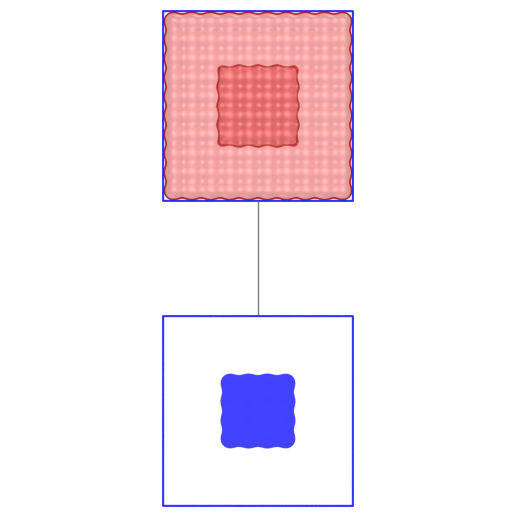

In [16]:
# Plot using nx matplotlib and the VMD images
draw_containment_nx(containers.containment_graph, containers._images, imsize=0.4, write=True, fname=f'{base_name}_containment.png', dpi=600)

## 2 - Nested Islands
A slightly more elaborate containment hierarchy, we still turn off blurring as we have voxel perfect input.

In [17]:
# Generate the test data
base_name = 'nested_islands_3D'
make_nested_island_3D(base_name + '.gro', visualize=False)

/home/bart/.virtualenvs/containment/lib/python3.8/site-packages/MDAnalysis/coordinates/GRO.py:421: UserWarning: Supplied AtomGroup was missing the following attributes: resnames, resids. These will be written with default values. Alternatively these can be supplied as keyword arguments.
  warnings.warn(


<Universe with 1000 atoms>

In [18]:
# Load the GRO
u = mda.Universe(base_name + '.gro')
selection = u.select_atoms('name is A')

/home/bart/.virtualenvs/containment/lib/python3.8/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: A
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))


In [19]:
# Generate the containment hierarchy
containers = mdvc.Containers(selection.atoms, resolution=1, blur_amount=0)

Creating voxel masks with a resolution of 1...
Blurring voxel masks with 0...
Non PBC-labeling...
Obtaining bridges...
Calculating the ranks...
The ranks are {(1,): 0, (2,): 0, (-2,): 0, (-1,): 3}
Calculating the pairs...
Relabeling taking PBC into account...
Creating graphs...
Annotating the containment graph...
Done!


In [20]:
# Write the components pdb (the components are in the beta field, the containment in the containment.vmd)
containers.write_components(fname_struc=f'{base_name}_containment.pdb', fname_vmd=f'{base_name}_containment.vmd')
; # suppresses the MDA printing

/home/bart/.virtualenvs/containment/lib/python3.8/site-packages/MDAnalysis/coordinates/PDB.py:1129: UserWarning: Found no information for attr: 'altLocs' Using default value of ' '
  warnings.warn("Found no information for attr: '{}'"
/home/bart/.virtualenvs/containment/lib/python3.8/site-packages/MDAnalysis/coordinates/PDB.py:1129: UserWarning: Found no information for attr: 'icodes' Using default value of ' '
  warnings.warn("Found no information for attr: '{}'"
/home/bart/.virtualenvs/containment/lib/python3.8/site-packages/MDAnalysis/coordinates/PDB.py:1129: UserWarning: Found no information for attr: 'chainIDs' Using default value of ''
  warnings.warn("Found no information for attr: '{}'"
/home/bart/.virtualenvs/containment/lib/python3.8/site-packages/MDAnalysis/coordinates/PDB.py:1129: UserWarning: Found no information for attr: 'occupancies' Using default value of '1.0'
  warnings.warn("Found no information for attr: '{}'"
/home/bart/.virtualenvs/containment/lib/python3.8/site-

'# suppresses the MDA printing'

In [21]:
## Show the objects (use as selection all, with visualization of VDW and coloring set to beta to see the components)
#visualize_3D(f'components_{base_name}.pdb', command_string='-e components.vmd')

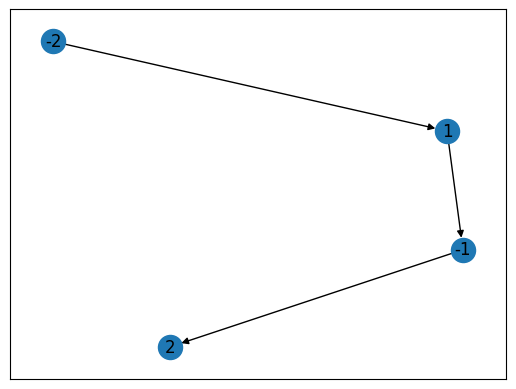

In [22]:
# Draw the raw containment graph using networkx
nx.draw_networkx(containers.containment_graph)

In [23]:
# Render using VMD
containers.render(prefix=base_name + '_')
containers.load_renders(prefix=base_name + '_')

/home/bart/.virtualenvs/containment/lib/python3.8/site-packages/MDAnalysis/coordinates/GRO.py:421: UserWarning: Supplied AtomGroup was missing the following attributes: names, resnames, resids. These will be written with default values. Alternatively these can be supplied as keyword arguments.
  warnings.warn(




Container -2
------------------------
{'UNK': 784}
I wrote nested_islands_3D_-2.gro
Info) VMD for LINUXAMD64, version 1.9.4a55 (November 26, 2021)
Info) http://www.ks.uiuc.edu/Research/vmd/                         
Info) Email questions and bug reports to vmd@ks.uiuc.edu           
Info) Please include this reference in published work using VMD:   
Info)    Humphrey, W., Dalke, A. and Schulten, K., `VMD - Visual   
Info)    Molecular Dynamics', J. Molec. Graphics 1996, 14.1, 33-38.
Info) -------------------------------------------------------------
Info) Multithreading available, 16 CPUs.
Info)   CPU features: SSE2 SSE4.1 AVX AVX2 FMA F16 HT 
Info) Free system memory: 27GB (86%)
Info) Creating CUDA device pool and initializing hardware...
Info) Detected 1 available CUDA accelerator::
Info) [0] Quadro T2000 with Max-Q Design 16 SM_7.5 1.4 GHz, 3.8GB RAM SP32 KT AE3 ZC
Info) OpenGL renderer: Mesa Intel(R) UHD Graphics (CML GT2)
Info)   Features: STENCIL MSAA(4) MDE CVA MTX NPOT PP PS G

/home/bart/.virtualenvs/containment/lib/python3.8/site-packages/pygraphviz/agraph.py:1407: RuntimeWarning: Warning: 1.0 is not a known color.

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


<module 'matplotlib.pyplot' from '/home/bart/.virtualenvs/containment/lib/python3.8/site-packages/matplotlib/pyplot.py'>

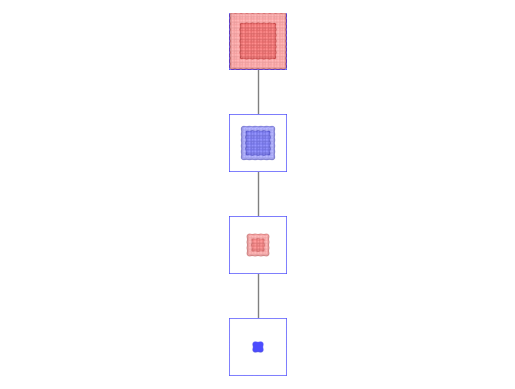

In [24]:
# Plot using nx matplotlib and the VMD images
draw_containment_nx(containers.containment_graph, containers._images, imsize=0.12, write=True, fname=f'{base_name}_containment.png', dpi=600)

# 3 - Nested Cylinders

In [25]:
# Generate the test data
base_name = 'nested_cylinders_3D'
make_cylinders_3D(base_name + '.gro', visualize=False)

/home/bart/.virtualenvs/containment/lib/python3.8/site-packages/MDAnalysis/coordinates/GRO.py:421: UserWarning: Supplied AtomGroup was missing the following attributes: resnames, resids. These will be written with default values. Alternatively these can be supplied as keyword arguments.
  warnings.warn(


<Universe with 1000 atoms>

In [26]:
# Load the GRO
u = mda.Universe(base_name + '.gro')
selection = u.select_atoms('name is A')

/home/bart/.virtualenvs/containment/lib/python3.8/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: A
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))


In [27]:
# Generate the containment hierarchy
containers = mdvc.Containers(selection.atoms, resolution=1, blur_amount=0)

Creating voxel masks with a resolution of 1...
Blurring voxel masks with 0...
Non PBC-labeling...
Obtaining bridges...
Calculating the ranks...
The ranks are {(1,): 1, (-2,): 1, (-1,): 3}
Calculating the pairs...
Relabeling taking PBC into account...
Creating graphs...
Annotating the containment graph...
Done!


In [28]:
# Write the components pdb (the components are in the beta field, the containment in the containment.vmd)
containers.write_components(fname_struc=f'{base_name}_containment.pdb', fname_vmd=f'{base_name}_containment.vmd')

/home/bart/.virtualenvs/containment/lib/python3.8/site-packages/MDAnalysis/coordinates/PDB.py:1129: UserWarning: Found no information for attr: 'altLocs' Using default value of ' '
  warnings.warn("Found no information for attr: '{}'"
/home/bart/.virtualenvs/containment/lib/python3.8/site-packages/MDAnalysis/coordinates/PDB.py:1129: UserWarning: Found no information for attr: 'icodes' Using default value of ' '
  warnings.warn("Found no information for attr: '{}'"
/home/bart/.virtualenvs/containment/lib/python3.8/site-packages/MDAnalysis/coordinates/PDB.py:1129: UserWarning: Found no information for attr: 'chainIDs' Using default value of ''
  warnings.warn("Found no information for attr: '{}'"
/home/bart/.virtualenvs/containment/lib/python3.8/site-packages/MDAnalysis/coordinates/PDB.py:1129: UserWarning: Found no information for attr: 'occupancies' Using default value of '1.0'
  warnings.warn("Found no information for attr: '{}'"
/home/bart/.virtualenvs/containment/lib/python3.8/site-

In [29]:
## Show the objects (use as selection all, with visualization of VDW and coloring set to beta to see the components)
#visualize_3D(f'{base_name}_containment.pdb', command_string='-e components.vmd')

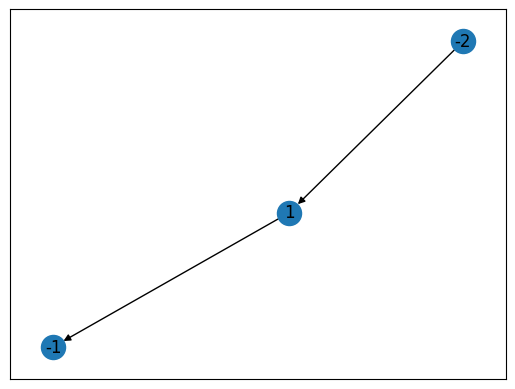

In [30]:
# Draw the raw containment graph using networkx
nx.draw_networkx(containers.containment_graph)

In [31]:
# Render using VMD
containers.render(prefix=base_name + '_')
containers.load_renders(prefix=base_name + '_')

/home/bart/.virtualenvs/containment/lib/python3.8/site-packages/MDAnalysis/coordinates/GRO.py:421: UserWarning: Supplied AtomGroup was missing the following attributes: names, resnames, resids. These will be written with default values. Alternatively these can be supplied as keyword arguments.
  warnings.warn(




Container -2
------------------------
{'UNK': 840}
I wrote nested_cylinders_3D_-2.gro
Info) VMD for LINUXAMD64, version 1.9.4a55 (November 26, 2021)
Info) http://www.ks.uiuc.edu/Research/vmd/                         
Info) Email questions and bug reports to vmd@ks.uiuc.edu           
Info) Please include this reference in published work using VMD:   
Info)    Humphrey, W., Dalke, A. and Schulten, K., `VMD - Visual   
Info)    Molecular Dynamics', J. Molec. Graphics 1996, 14.1, 33-38.
Info) -------------------------------------------------------------
Info) Multithreading available, 16 CPUs.
Info)   CPU features: SSE2 SSE4.1 AVX AVX2 FMA F16 HT 
Info) Free system memory: 27GB (86%)
Info) Creating CUDA device pool and initializing hardware...
Info) Detected 1 available CUDA accelerator::
Info) [0] Quadro T2000 with Max-Q Design 16 SM_7.5 1.4 GHz, 3.8GB RAM SP32 KT AE3 ZC
Info) OpenGL renderer: Mesa Intel(R) UHD Graphics (CML GT2)
Info)   Features: STENCIL MSAA(4) MDE CVA MTX NPOT PP PS

/home/bart/.virtualenvs/containment/lib/python3.8/site-packages/pygraphviz/agraph.py:1407: RuntimeWarning: Warning: 1.0 is not a known color.

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


<module 'matplotlib.pyplot' from '/home/bart/.virtualenvs/containment/lib/python3.8/site-packages/matplotlib/pyplot.py'>

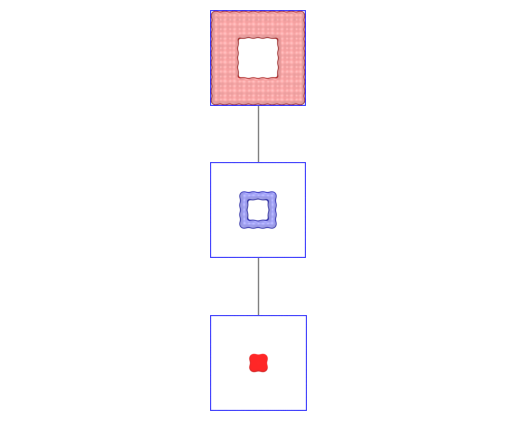

In [32]:
# Plot using nx matplotlib and the VMD images
draw_containment_nx(containers.containment_graph, containers._images, imsize=0.2, write=True, fname=f'{base_name}_containment.png', dpi=600)

# 4 -  Complex containment

In [33]:
# Generate the test data
base_name = 'complex_3D'
make_complex_3D(base_name + '.gro', visualize=False)

/home/bart/.virtualenvs/containment/lib/python3.8/site-packages/MDAnalysis/coordinates/GRO.py:421: UserWarning: Supplied AtomGroup was missing the following attributes: resnames, resids. These will be written with default values. Alternatively these can be supplied as keyword arguments.
  warnings.warn(


<Universe with 2300 atoms>

In [34]:
# Load the GRO
u = mda.Universe(base_name + '.gro')
selection = u.select_atoms('name is A')

/home/bart/.virtualenvs/containment/lib/python3.8/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: A
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))


In [35]:
# Generate the containment hierarchy
containers = mdvc.Containers(selection.atoms, resolution=1, blur_amount=0)

Creating voxel masks with a resolution of 1...
Blurring voxel masks with 0...
Non PBC-labeling...
Obtaining bridges...
Calculating the ranks...
The ranks are {(1,): 1, (2,): 2, (3,): 0, (4,): 0, (-5,): 0, (-4, -1): 2, (-3,): 0, (-2,): 1}
Calculating the pairs...
Relabeling taking PBC into account...
Creating graphs...
Annotating the containment graph...
Done!


In [36]:
# Write the components pdb (the components are in the beta field, the containment in the containment.vmd)
containers.write_components(fname_struc=f'{base_name}_containment.pdb', fname_vmd=f'{base_name}_containment.vmd')

/home/bart/.virtualenvs/containment/lib/python3.8/site-packages/MDAnalysis/coordinates/PDB.py:1129: UserWarning: Found no information for attr: 'altLocs' Using default value of ' '
  warnings.warn("Found no information for attr: '{}'"
/home/bart/.virtualenvs/containment/lib/python3.8/site-packages/MDAnalysis/coordinates/PDB.py:1129: UserWarning: Found no information for attr: 'icodes' Using default value of ' '
  warnings.warn("Found no information for attr: '{}'"
/home/bart/.virtualenvs/containment/lib/python3.8/site-packages/MDAnalysis/coordinates/PDB.py:1129: UserWarning: Found no information for attr: 'chainIDs' Using default value of ''
  warnings.warn("Found no information for attr: '{}'"
/home/bart/.virtualenvs/containment/lib/python3.8/site-packages/MDAnalysis/coordinates/PDB.py:1129: UserWarning: Found no information for attr: 'occupancies' Using default value of '1.0'
  warnings.warn("Found no information for attr: '{}'"
/home/bart/.virtualenvs/containment/lib/python3.8/site-

In [37]:
## Show the objects (use as selection all, with visualization of VDW and coloring set to beta to see the components)
#visualize_3D(f'{base_name}_containment.pdb', command_string='-e components.vmd')

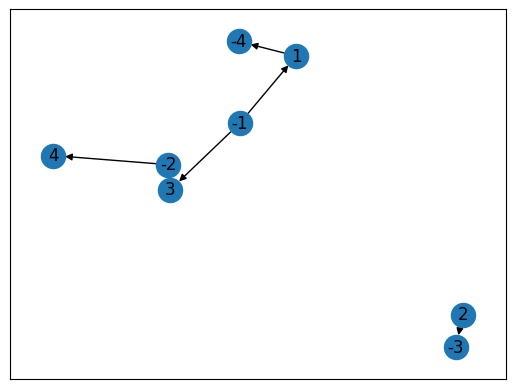

In [38]:
# Draw the raw containment graph using networkx
nx.draw_networkx(containers.containment_graph, )

In [39]:
# Render using VMD
containers.render(prefix=base_name + '_')
containers.load_renders(prefix=base_name + '_')

/home/bart/.virtualenvs/containment/lib/python3.8/site-packages/MDAnalysis/coordinates/GRO.py:421: UserWarning: Supplied AtomGroup was missing the following attributes: names, resnames, resids. These will be written with default values. Alternatively these can be supplied as keyword arguments.
  warnings.warn(




Container -4
------------------------
{'UNK': 40}
I wrote complex_3D_-4.gro
Info) VMD for LINUXAMD64, version 1.9.4a55 (November 26, 2021)
Info) http://www.ks.uiuc.edu/Research/vmd/                         
Info) Email questions and bug reports to vmd@ks.uiuc.edu           
Info) Please include this reference in published work using VMD:   
Info)    Humphrey, W., Dalke, A. and Schulten, K., `VMD - Visual   
Info)    Molecular Dynamics', J. Molec. Graphics 1996, 14.1, 33-38.
Info) -------------------------------------------------------------
Info) Multithreading available, 16 CPUs.
Info)   CPU features: SSE2 SSE4.1 AVX AVX2 FMA F16 HT 
Info) Free system memory: 27GB (86%)
Info) Creating CUDA device pool and initializing hardware...
Info) Detected 1 available CUDA accelerator::
Info) [0] Quadro T2000 with Max-Q Design 16 SM_7.5 1.4 GHz, 3.8GB RAM SP32 KT AE3 ZC
Info) OpenGL renderer: Mesa Intel(R) UHD Graphics (CML GT2)
Info)   Features: STENCIL MSAA(4) MDE CVA MTX NPOT PP PS GLSL(OVFS

/home/bart/.virtualenvs/containment/lib/python3.8/site-packages/pygraphviz/agraph.py:1407: RuntimeWarning: Warning: 0.024630541871921183 is not a known color.

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


<module 'matplotlib.pyplot' from '/home/bart/.virtualenvs/containment/lib/python3.8/site-packages/matplotlib/pyplot.py'>

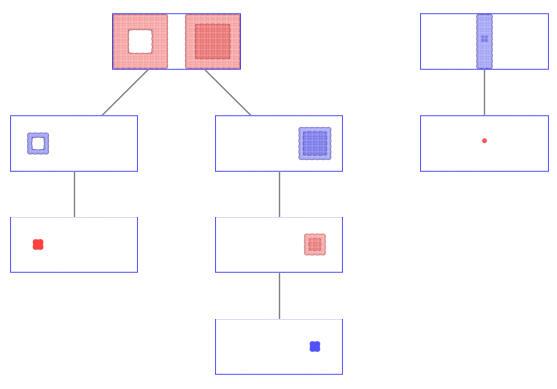

In [40]:
# Plot using nx matplotlib and the VMD images
draw_containment_nx(containers.containment_graph, containers._images, imsize=0.2, write=True, fname=f'{base_name}_containment.png', dpi=600)

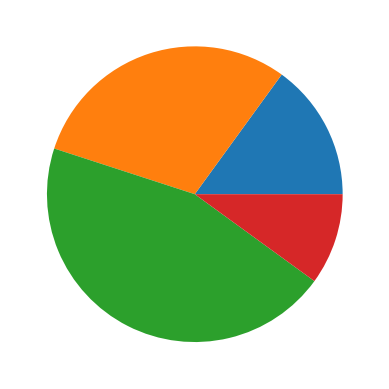

In [6]:
import matplotlib.pyplot as plt
labels = 'Frogs', 'Hogs', 'Dogs', 'Logs'
sizes = [15, 30, 45, 10]

fig, ax = plt.subplots()
ax.pie(sizes,)
plt.show()